In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import torch
import torch.optim as optim
import multiprocessing as mp
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.math import *
from uniswapv3_simulator.optimization.environments import OneStepEnvironment, ScaleWrapper
from uniswapv3_simulator.optimization.ddpg.ddpg import (
    DDPG,
    DDPGTrainer,
    DeepActorModel,
    TrainArgs
)
from uniswapv3_simulator.optimization.ddpg.exploration_noise import GaussianProcess
from uniswapv3_simulator.optimization.ddpg.schedulers import ExponentialScheduler

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(
    level=logging.INFO,
    filename=f'./logs/rl_test_{timestamp}.log'
)
logging.getLogger('optimization').setLevel(logging.DEBUG)

In [2]:
SEED = 1234
seed_seq = np.random.SeedSequence(entropy=SEED)
seeds = seed_seq.generate_state(8)

init_price = 100
liquidity_bins = [80, 85, 90, 95, 100, 105, 110, 115, 120]

# fees = stats.uniform(1e-4, 0.01 - 1e-4)
# mu = stats.uniform(-0.05, 0.1)
# sigma = stats.uniform(1e-4, 0.1 - 1e-4) 
# alpha = stats.randint(1, 100 + 1)
# beta = stats.randint(100, 1000 + 1)

fees = stats.uniform(0.01, 0.0)
mu = stats.uniform(0.0, 0.0)
sigma = stats.uniform(1e-4, 0.1 - 1e-4)  # vary sigma
alpha = stats.randint(50, 50 + 1)
beta = stats.randint(500, 500 + 1)

fees.random_state = seeds[0]
mu.random_state = seeds[1]
sigma.random_state = seeds[2]
alpha.random_state = seeds[3]
beta.random_state = seeds[4]

n_sims_per_step = 500
#n_jobs = int(mp.cpu_count() / 2) - 1
n_jobs = 45

env = OneStepEnvironment(
    init_price, liquidity_bins,
    fees, mu, sigma, alpha, beta,
    n_sims_per_step=n_sims_per_step, 
    n_jobs=n_jobs, seed=seeds[5]
)

In [9]:
print('Random Variables')
print(f'fees:  mean={fees.mean():,.4f}, std={fees.std():,.4f}')
print(f'mu:    mean={mu.mean():,.4f}, std={mu.std():,.4f}')
print(f'sigma: mean={sigma.mean():,.4f}, std={sigma.std():,.4f}')
print(f'alpha: mean={alpha.mean():,.2f}, std={alpha.std():,.2f}')
print(f'beta:  mean={beta.mean():,.2f}, std={beta.std():,.2f}')

Random Variables
fees:  mean=nan, std=nan
mu:    mean=nan, std=nan
sigma: mean=0.0501, std=0.0288
alpha: mean=50.00, std=0.00
beta:  mean=500.00, std=0.00


/Users/pspalding/opt/anaconda3/envs/rl_env/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:1035: RuntimeWarning: divide by zero encountered in true_divide
  g2 = -6.0/5.0 * (d*d + 1.0) / (d*d - 1.0)


In [10]:
def obs_scale_fn(obs):
    obs = obs[[2]]
    mu = np.array([0.0501])
    sigma = np.array([0.0288])
    # mu =    np.array([0.0051, 0.0000, 0.0501, 50.50, 550.00])
    # sigma = np.array([0.0029, 0.0289, 0.0288, 28.87, 260.10])
    
    return (obs - mu) / sigma

def action_scale_fn(action):
    return action * 1e+5

def reward_scale_fn(reward):
    return reward * 1e+2

env = ScaleWrapper(env, obs_scale_fn, action_scale_fn, reward_scale_fn)

In [5]:
torch.manual_seed(seeds[6])
action_size = len(liquidity_bins) - 1
model = DeepActorModel(1, action_size, (128, 64), (128, 64))
agent = DDPG(
    model=model,
    gamma=0.99,
    tau=1e-3,
    optimizer=optim.Adam,
    actor_optimizer_kwargs={
        'lr': 1e-4,
        'weight_decay': 1e-5
    },
    critic_optimizer_kwargs={
        'lr': 1e-3,
        'weight_decay': 1e-5
    },
    clip_gradients=10.0
)
train_args = TrainArgs(
    train_steps=3000,
    batch_size=64, 
    memory_size=100000,
    exploration_noise=GaussianProcess,
    noise_kwargs={
        'size': (action_size, ), 
        'std': ExponentialScheduler(0.2, 0.01, 0.9995)
    },
    update_start=50,
    update_freq=2,
    clip_actions=(1e-6, np.inf),
    seed=seeds[7]
)
trainer = DDPGTrainer(agent, env, train_args)

In [6]:
model

DeepActorModel(
  (critic_layers): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor_layers): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=8, bias=True)
  )
)

In [7]:
%%time
rewards = trainer.train()

Episode:    50 | Mean Score: -0.463546
Episode:   100 | Mean Score: -0.423065
Episode:   150 | Mean Score: -0.472060
Episode:   200 | Mean Score: -0.419245
Episode:   250 | Mean Score: -0.349165
Episode:   300 | Mean Score: -0.290754
Episode:   350 | Mean Score: -0.332995
Episode:   400 | Mean Score: -0.326541
Episode:   450 | Mean Score: -0.334267
Episode:   500 | Mean Score: -0.305635
Episode:   550 | Mean Score: -0.291043
Episode:   600 | Mean Score: -0.311871
Episode:   650 | Mean Score: -0.308196
Episode:   700 | Mean Score: -0.274364
Episode:   750 | Mean Score: -0.297545
Episode:   800 | Mean Score: -0.251920
Episode:   850 | Mean Score: -0.281316
Episode:   900 | Mean Score: -0.304151
Episode:   950 | Mean Score: -0.271567
Episode: 1,000 | Mean Score: -0.290362
Episode: 1,050 | Mean Score: -0.248298
Episode: 1,100 | Mean Score: -0.251370
Episode: 1,150 | Mean Score: -0.249027
Episode: 1,200 | Mean Score: -0.295608
Episode: 1,250 | Mean Score: -0.239582
Episode: 1,300 | Mean Sco

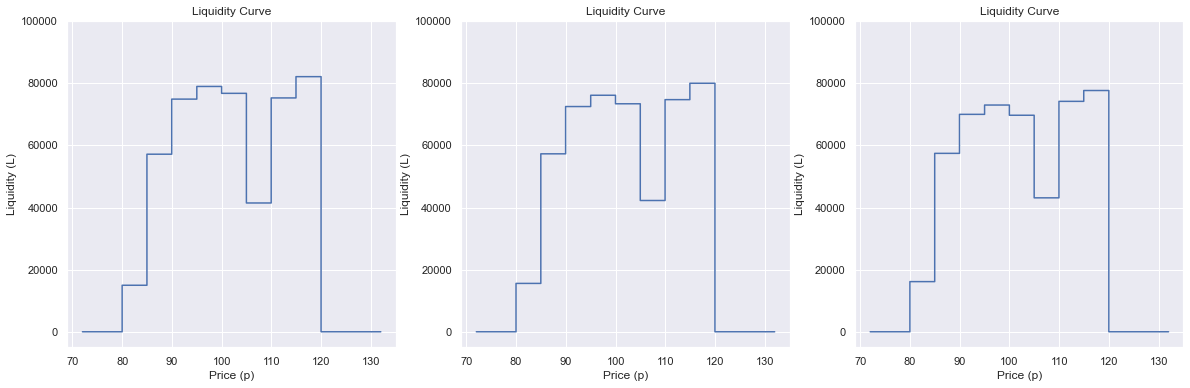

In [5]:
agent = pd.read_pickle('/Users/pspalding/Downloads/V2/agent.pickle')
sigma = [1e-4, 0.05, 0.1]
actions = []

for s in sigma:
    actions.append(agent.action([s]))

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for j, action in enumerate(actions):
    pool = Uniswapv3Pool(0.01, 1, init_price)
    action *= 1e+5
    for i in range(len(action)):
        account_id = f'position_{i + 1}'
        tick_lower = sqrt_price_to_tick(liquidity_bins[i] ** 0.5)
        tick_upper = sqrt_price_to_tick(liquidity_bins[i + 1] ** 0.5)
        liquidity = action[i]
        token0, token1 = pool.set_position(
            account_id,
            tick_lower,
            tick_upper,
            liquidity
        )
    pool.plot_liquidity_curve(ax=ax[j])
    ax[j].set_ylim(-5e+3, 1e+5)
    
plt.show()

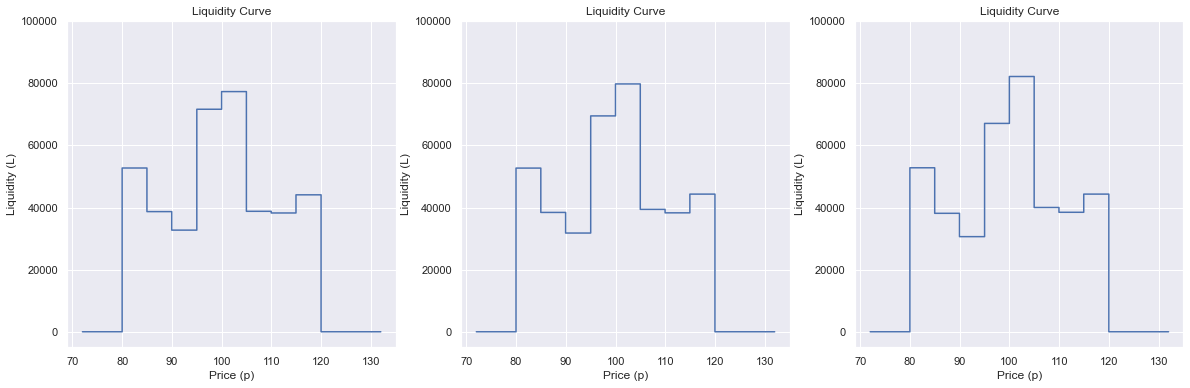

In [6]:
agent = pd.read_pickle('/Users/pspalding/Downloads/V3/agent.pickle')
sigma = [-0.05, 0, 0.05]
actions = []

for s in sigma:
    actions.append(agent.action([s]))
    
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for j, action in enumerate(actions):
    pool = Uniswapv3Pool(0.01, 1, init_price)
    action *= 1e+5
    for i in range(len(action)):
        account_id = f'position_{i + 1}'
        tick_lower = sqrt_price_to_tick(liquidity_bins[i] ** 0.5)
        tick_upper = sqrt_price_to_tick(liquidity_bins[i + 1] ** 0.5)
        liquidity = action[i]
        token0, token1 = pool.set_position(
            account_id,
            tick_lower,
            tick_upper,
            liquidity
        )
    pool.plot_liquidity_curve(ax=ax[j])
    ax[j].set_ylim(-5e+3, 1e+5)
    
plt.show()

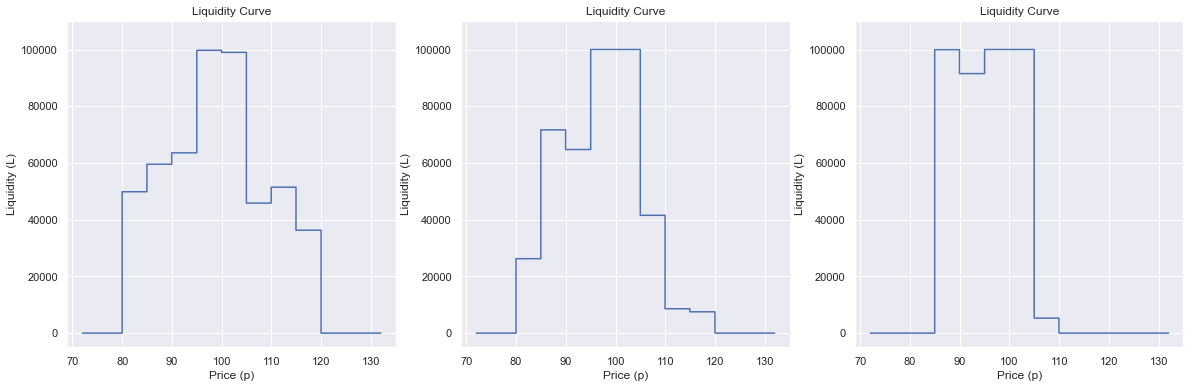

In [11]:
agent = pd.read_pickle('/Users/pspalding/Downloads/V4/agent.pickle')
sigma = [1, 5, 50]
actions = []

for s in sigma:
    actions.append(agent.action([s]))

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for j, action in enumerate(actions):
    pool = Uniswapv3Pool(0.01, 1, init_price)
    action *= 1e+5
    for i in range(len(action)):
        account_id = f'position_{i + 1}'
        tick_lower = sqrt_price_to_tick(liquidity_bins[i] ** 0.5)
        tick_upper = sqrt_price_to_tick(liquidity_bins[i + 1] ** 0.5)
        liquidity = action[i]
        token0, token1 = pool.set_position(
            account_id,
            tick_lower,
            tick_upper,
            liquidity
        )
    pool.plot_liquidity_curve(ax=ax[j])
    ax[j].set_ylim(-5e+3, 1e+5 * 1.1)
    
plt.show()

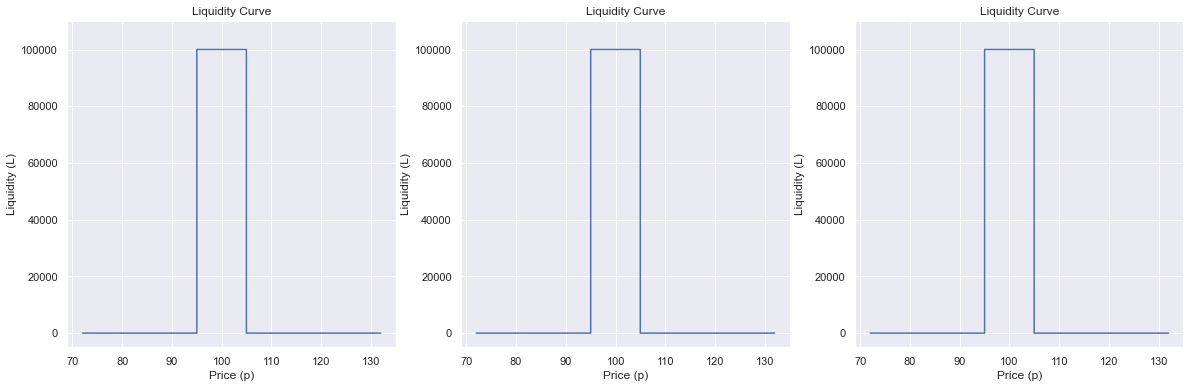

In [3]:
agent = pd.read_pickle('/Users/pspalding/Downloads/V5/agent.pickle')
sigma = [1000, 5000, 10000]
actions = []

for s in sigma:
    actions.append(agent.action([s]))

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for j, action in enumerate(actions):
    pool = Uniswapv3Pool(0.01, 1, init_price)
    action *= 1e+5
    for i in range(len(action)):
        account_id = f'position_{i + 1}'
        tick_lower = sqrt_price_to_tick(liquidity_bins[i] ** 0.5)
        tick_upper = sqrt_price_to_tick(liquidity_bins[i + 1] ** 0.5)
        liquidity = action[i]
        token0, token1 = pool.set_position(
            account_id,
            tick_lower,
            tick_upper,
            liquidity
        )
    pool.plot_liquidity_curve(ax=ax[j])
    ax[j].set_ylim(-5e+3, 1e+5 * 1.1)
    
plt.show()

In [8]:
actions

[array([49841.816, 59551.848, 63562.418, 99714.81 , 98986.26 , 45839.88 ,
        51459.23 , 36284.33 ], dtype=float32),
 array([1.0971604e-01, 9.9932273e+04, 9.1502789e+04, 1.0000000e+05,
        1.0000000e+05, 5.2819688e+03, 1.7575990e-08, 8.0657574e-06],
       dtype=float32),
 array([8.2210207e-08, 9.9999938e+04, 9.8755797e+04, 1.0000000e+05,
        1.0000000e+05, 3.1742969e+02, 1.7134216e-21, 7.6291141e-16],
       dtype=float32)]

<AxesSubplot:title={'center':'Liquidity Curve'}, xlabel='Price (p)', ylabel='Liquidity (L)'>

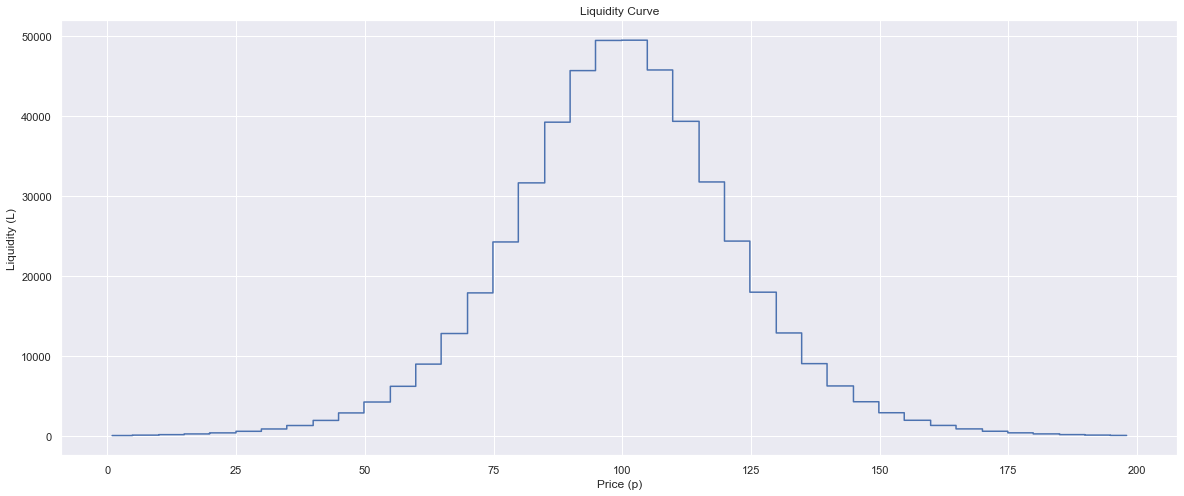

In [21]:
from uniswapv3_simulator.utils import *
pool = Uniswapv3Pool(0.01, 1, 100)
def sech2_fn(p, mu, s, c):
    # sech = 1 / cosh
    return c * (1 / np.cosh((p - mu) / s)) ** 2
curve_params = (100, 25, 50000)
set_positions(pool, lambda p: sech2_fn(p, *curve_params), 5, 0, 200,
              min_liquidity=1, position_id='LP1')
pool.plot_liquidity_curve(interval=(1, 180))